# Web Scraping for Indeed.com and Predicting Salaries

### Task

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).


### Import Packages

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import requests
import bs4
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import time

In [3]:
pd.set_option('display.max_rows', None)

### Functions to extract company, job, and salary.


In [4]:
def get_title(html):
    try:
        return html.find('a', attrs = {'data-tn-element': 'jobTitle'}).text.replace('\n','')
    except:
        return None

In [5]:
def get_company(html):
    try:
        return html.find('span', attrs = {'class': 'company'}).text.replace('\n','')
    except:
        return None

In [7]:
def get_salary(html):
    try:
        return html.find('span', attrs = {'class': 'salaryText'}).text.replace('\n','')
    except:
        return None

### Web Scraping

In [8]:
# cities to include in the search

cities = ['Nottingham', 'Birmingham','Manchester','Leeds','Reading','Glasgow','Edinburgh','Newcastle',
          'Liverpool','Bristol','Oxford','Cambridge','London', 'Belfast']

In [9]:
# the url includes search for data scientist, data analyst, data engineer or data science
# radius is 25 miles

url = 'https://www.indeed.co.uk/jobs?q=%22data%22+AND+%28%22scientist%22+OR+%22analyst%22+OR+%22engineer%22+OR+%22science%22%29&l={}&start={}'


In [10]:
result = []
title = []
company = []
area = []
salary = []

for city in cities:
    for i in tqdm(range(0, 950, 10)):
        time.sleep(1)            
        r = requests.get(url.format(city, i))
        soup = BeautifulSoup(r.text, 'html.parser')
        
        for post in soup.find_all('div', attrs = {'class': "result"}):
            result.extend(post)
            title.append(get_title(post)) 
            company.append(get_company(post)) 
            area.append(city) 
            salary.append(get_salary(post)) 
            
            
        

100%|██████████| 95/95 [02:24<00:00,  1.52s/it]


In [11]:
df = pd.DataFrame({'title': title, 'company': company, 'area': area,
                   'salary': salary } )

In [12]:
df.shape

(24150, 4)

In [14]:
df.duplicated().sum()

16175

In [15]:
# remove duplicates
df.drop_duplicates(inplace = True)

In [17]:
df.isnull().sum()

title         0
company       4
area          0
salary     5148
dtype: int64

In [19]:
# remove job posting that dont include salary
df.dropna(inplace = True)

In [31]:
# only keep salaries per year
df.drop(df[~df['salary'].str.contains('a year')].index, inplace = True)

In [33]:
df.shape

(2509, 4)

In [37]:
# function that takes a salary string and converts it to a number, averaging a salary range if necessary

def salary_clean(df_col):
    new_column = []
    for i in df_col.map(lambda x: x.replace(' a year', '').replace('£','').replace(',','').split('-')):
        x = np.array(i, dtype= int)
        new_column.append(np.mean(x)) 
    return new_column

In [39]:
df.salary = salary_clean(df.salary)

In [40]:
df.head()

,title,company,area,salary
4,Treasury & Asset Analyst,Nottingham Community Housing Association,Nottingham,24029.5
6,Data Analyst,My Talent Hub,Nottingham,25000.0
7,Junior Data Scientist,Oscar Technology,Nottingham,35000.0
8,HR Data Analyst,Derbyshire County Council,Nottingham,25977.0
10,111 Workforce and Performance Insight Analyst,DHU Health Care CIC,Nottingham,35000.0


In [ ]:
df_final = df.reset_index(drop = True)
df_final.to_csv("indeed_jobs.csv", index = False)

### Create binary variable: whether the salary is lower or higher than median

In [114]:
jobs = pd.read_csv('indeed_jobs.csv')

In [116]:
jobs.area.value_counts()

Manchester    313
Oxford        295
Reading       283
London        260
Birmingham    241
Leeds         193
Cambridge     191
Bristol       171
Liverpool     141
Nottingham    116
Newcastle      82
Edinburgh      82
Belfast        76
Glasgow        65
Name: area, dtype: int64

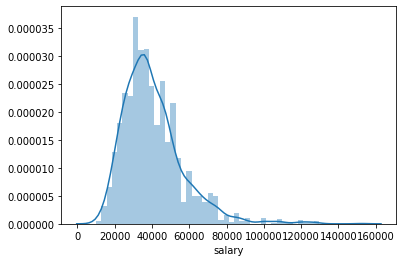

In [118]:
sns.distplot(jobs.salary);

In [119]:
jobs.salary.mean()

40585.84754882423

In [120]:
jobs.salary.median()

37500.0

In [121]:
salary_high_low = jobs.salary.map(lambda x: 1 if x >= jobs.salary.median() else 0)

In [122]:
jobs['salary_high_low'] = salary_high_low

#### What is the baseline accuracy for this model?

In [123]:
print('Baseline accuracy:',jobs.salary_high_low.value_counts(normalize = True).max())

Baseline accuracy: 0.5173375846950976


### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

### Classification model with only location as feature

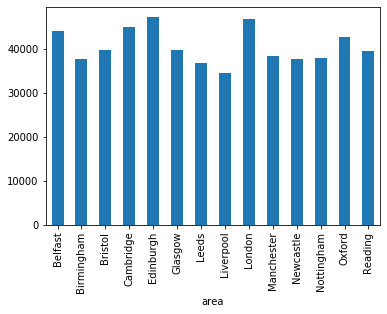

In [124]:
jobs.groupby('area').salary.mean().plot(kind = 'bar');

In [125]:
y = jobs.salary_high_low
X = pd.get_dummies(jobs.area)

In [126]:
# dropping liverpool because it has the lowest mean salary
X.drop('Liverpool', axis = 1, inplace = True)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=1)

In [71]:
scaler = StandardScaler()

In [72]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [74]:
# set up grid search with logistic regression model

lr = LogisticRegression()

lr_params = {'C': np.logspace(-4, 4, 10),
          'penalty': ['l1', 'l2'],
          'fit_intercept': [True, False],
          'solver': ['liblinear','lbfgs', 'saga']}

gs_lr = GridSearchCV(estimator=lr,
                     param_grid=lr_params,
                     cv=5,
                     verbose = 1,
                    n_jobs = 2)



In [75]:
gs_lr.fit(X_train,y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 553 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done 600 out of 600 | elapsed:    4.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'],
                         'solver': 

In [77]:
# extract the grid search results

print('Best Parameters:')
print(gs_lr.best_params_)
print('Best estimator C:')
print(gs_lr.best_estimator_.C)
print('Best estimator mean cross validated training score:')
print(gs_lr.best_score_)
print('Best estimator score on the full training set:')
print(gs_lr.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs_lr.score(X_test, y_test))
print('Best estimator coefficients:')
print(gs_lr.best_estimator_.coef_)

Best Parameters:
{'C': 0.046415888336127774, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}
Best estimator C:
0.046415888336127774
Best estimator mean cross validated training score:
0.5739779903475143
Best estimator score on the full training set:
0.5739910313901345
Best estimator score on the test set:
0.5438247011952191
Best estimator coefficients:
[[ 0.06580126 -0.00182681  0.06824915  0.19994398  0.072063    0.
  -0.00468359  0.17523834  0.          0.         -0.01790447  0.
  -0.00374226]]


In [85]:
pd.DataFrame(gs_lr.best_estimator_.coef_, columns = [X_train.columns], index = ['coeff']).T.sort_values('coeff', ascending = False)


,coeff
Cambridge,0.199944
London,0.175238
Edinburgh,0.072063
Bristol,0.068249
Belfast,0.065801
Glasgow,0.000000
Manchester,0.000000
Newcastle,0.000000
Oxford,0.000000
Birmingham,-0.001827


In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

In [88]:
dtc = DecisionTreeClassifier()

dtc_params = {
    'max_depth': list(range(1, 10))+[None],
    'criterion': ['gini', 'entropy'],
    'max_features': list(range(1, 10))+[None],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.01]
}


gs_dtc = GridSearchCV(dtc, dtc_params, cv=5, verbose=1, n_jobs=2)

In [89]:
gs_dtc.fit(X_train, y_train)

Fitting 5 folds for each of 8800 candidates, totalling 44000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 460 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 5260 tasks      | elapsed:   21.9s
[Parallel(n_jobs=2)]: Done 13260 tasks      | elapsed:   57.6s
[Parallel(n_jobs=2)]: Done 24460 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 38860 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done 44000 out of 44000 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=2,
             param_grid={'ccp_alpha': [0, 0.001, 0.005, 0.01],
                  

In [94]:
gs_dtc.best_estimator_

DecisionTreeClassifier(ccp_alpha=0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=25,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [92]:
print('Best Parameters:')
print(gs_dtc.best_params_)
print('Best estimator mean cross validated training score:')
print(gs_dtc.best_score_)
print('Best estimator score on the full training set:')
print(gs_dtc.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs_dtc.score(X_test, y_test))


Best Parameters:
{'ccp_alpha': 0, 'criterion': 'gini', 'max_depth': 6, 'max_features': 8, 'min_samples_split': 25}
Best estimator mean cross validated training score:
0.5739817123857025
Best estimator score on the full training set:
0.5749875435974091
Best estimator score on the test set:
0.5537848605577689


In [142]:
from sklearn.ensemble import AdaBoostClassifier

In [95]:
ada_boost = AdaBoostClassifier(base_estimator=gs_dtc.best_estimator_,
                           n_estimators=100,
                           random_state=1)

ada_boost.fit(X_train, y_train)


print('Best estimator mean cross validated training score:')
print(cross_val_score(ada_boost, X_train, y_train, cv=5).mean())
print('Best estimator score on the full training set:')
print(ada_boost.score(X_train, y_train))
print('Best estimator score on the test set:')
print(ada_boost.score(X_test, y_test))

Best estimator mean cross validated training score:
0.5704966439622338
Best estimator score on the full training set:
0.5769805680119582
Best estimator score on the test set:
0.5677290836653387


In [128]:
# CV of LogisticRegression with GridSearch: 0.5739779903475143
# CV of DecisionTreeClassifier with GridSearch: 0.5739817123857025 and Boosting: 0.5704966439622338
# Baseline accuracy: 0.5173375846950976

# Despite LogisticRegression model being better than baseline and DecisionTreeClassifier, the score is not impressive

### Categorise company and title

In [129]:
jobs.shape

(2509, 6)

In [130]:
jobs.head()

,Unnamed: 0,title,company,area,salary,salary_high_low
0,0,Treasury & Asset Analyst,Nottingham Community Housing Association,Nottingham,24029.5,0
1,1,Data Analyst,My Talent Hub,Nottingham,25000.0,0
2,2,Junior Data Scientist,Oscar Technology,Nottingham,35000.0,0
3,3,HR Data Analyst,Derbyshire County Council,Nottingham,25977.0,0
4,4,111 Workforce and Performance Insight Analyst,DHU Health Care CIC,Nottingham,35000.0,0


In [131]:
# In this section I will categorise job titles and companies by key words and sector, eventually joining them into a 
# single dataframe that I will use for my predictions 

In [132]:
# These are the most common key words in job titles

job_categories = ['director', 'analyst', 'scientist', 'engineer', 'business', 'consultant', 'senior', 'junior', 
                  'manager', 'officer', 'developer', 'head', 'programmer', 'executive', 'java', 'python', 'lead',
                  'intelligence', 'machine learning', 'javascript', 'graduate', 'research', 'intern']

In [133]:
df_categories = pd.DataFrame(columns = job_categories )

In [134]:
for job in job_categories:
    df_categories[job] = jobs.title.map(lambda x: 1 if job.lower() in x.lower() else 0)


In [135]:
# I create a dataframe with 1 and 0 if the keyword is contained in the job title

In [136]:
df_categories.head()

,director,analyst,scientist,engineer,business,consultant,senior,junior,manager,officer,...,executive,java,python,lead,intelligence,machine learning,javascript,graduate,research,intern
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [137]:
df_categories.shape

(2509, 23)

In [138]:
# the keywords are not evenly distributed but could still be helpful for predictions

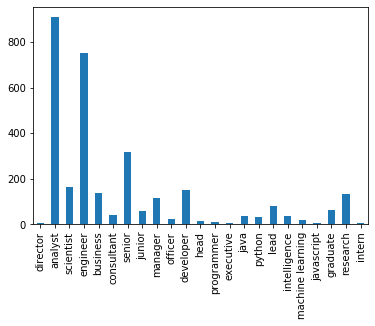

In [139]:
df_categories.sum().plot(kind = 'bar');

In [140]:
# these are the main job sectors that I spotted in the company names, unfortunaly here is harder to generalise to 
# categories

In [141]:
job_sectors = {'recruitment': ['Harnham','Ampersand', 'VANRATH', 'Page', 'ECM', 'Selection', 'Recruitment',
                              'Recruit', 'Client', 'Ronald', 'MBN', 'myfuturerole.com', 'Oscar',
                              'Modis'],
              'healthcare': ['Healthcare', 'Health', 'NHS', 'Hospital', 'Patient', 'Medicine', 'Medical'],
              'government': ['Government', 'Ministry', 'Public', 'National', 'BBC', 'STFC', 'HM'],
              'banking': ['Bank','Finance'],
              'consulting': ['Consulting','Consultancy'],
              'energy': ['Energy', 'Gas', 'Utilities'],
              'education': ['College', 'School', 'University']}



In [142]:
df_sector = pd.DataFrame(columns = job_sectors.keys())

In [143]:
for sector in df_sector:
    df_sector[sector] = jobs.company.map(lambda x:1 if any(i in job_sectors[sector] for i in x.split(' ')) else 0)

In [144]:
df_sector.head()

,recruitment,healthcare,government,banking,consulting,energy,education
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0


In [145]:
df_sector.shape

(2509, 7)

In [146]:
# the dataframe of job sectors is highly unbalanced because mainly recruitment companies choose to advertise the 
# salary in the job posting

# since jobs posted by recruitment companies can be in very different sectors, this dataframe might not be very 
# helpful in predicting salary

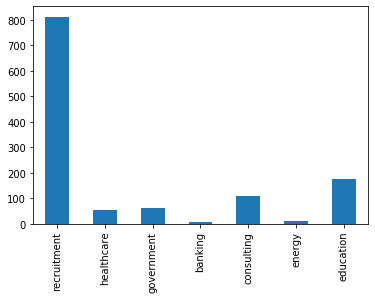

In [147]:
df_sector.sum().plot(kind = 'bar');

In [148]:
final_jobs = pd.concat([jobs[['salary_high_low']],X, df_sector, df_categories], axis = 1 )

In [149]:
final_jobs.head()

,salary_high_low,Belfast,Birmingham,Bristol,Cambridge,Edinburgh,Glasgow,Leeds,London,Manchester,...,executive,java,python,lead,intelligence,machine learning,javascript,graduate,research,intern
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
final_jobs.columns

Index(['salary_high_low', 'Belfast', 'Birmingham', 'Bristol', 'Cambridge',
       'Edinburgh', 'Glasgow', 'Leeds', 'London', 'Manchester', 'Newcastle',
       'Nottingham', 'Oxford', 'Reading', 'recruitment', 'healthcare',
       'government', 'banking', 'consulting', 'energy', 'education',
       'director', 'analyst', 'scientist', 'engineer', 'business',
       'consultant', 'senior', 'junior', 'manager', 'officer', 'developer',
       'head', 'programmer', 'executive', 'java', 'python', 'lead',
       'intelligence', 'machine learning', 'javascript', 'graduate',
       'research', 'intern'],
      dtype='object')

In [ ]:
final_jobs.to_csv("indeed_final.csv", index = False)

### Multi-feature modelling with Logistic Regression

In [6]:
final_jobs = pd.read_csv("indeed_final.csv")

In [9]:
y = final_jobs.salary_high_low

In [10]:
X = final_jobs.drop('salary_high_low', axis = 1)

In [11]:
from scipy import sparse

In [12]:
matrix = sparse.csr_matrix(X.values)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(matrix, y, stratify=y, test_size=0.2, random_state=1)

In [20]:
# set up grid search with logistic regression model

lr = LogisticRegression()

lr_params = {'C': np.logspace(-4, 4, 10),
          'penalty': ['l1', 'l2'],
          'fit_intercept': [True, False],
          'solver': ['liblinear','lbfgs', 'saga']}

gs_lr = GridSearchCV(estimator=lr,
                     param_grid=lr_params,
                     cv=5,
                     verbose = 1,
                    n_jobs = 2)



In [21]:
gs_lr.fit(X_train,y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 274 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done 600 out of 600 | elapsed:   10.0s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=2,
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'],
                         'solver': 

In [22]:
# extract the grid search results

print('Best Parameters:')
print(gs_lr.best_params_)
print('Best estimator C:')
print(gs_lr.best_estimator_.C)
print('Best estimator mean cross validated training score:')
print(gs_lr.best_score_)
print('Best estimator score on the full training set:')
print(gs_lr.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs_lr.score(X_test, y_test))
print('Best estimator coefficients:')
print(gs_lr.best_estimator_.coef_)

Best Parameters:
{'C': 21.54434690031882, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}
Best estimator C:
21.54434690031882
Best estimator mean cross validated training score:
0.6940484609372093
Best estimator score on the full training set:
0.7090184354758345
Best estimator score on the test set:
0.7231075697211156
Best estimator coefficients:
[[ 0.31335816  0.11041189  0.67577599  1.12497667  0.87709198  0.61254201
   0.13979896  1.61008448  0.20586985 -0.07126146 -0.08260684  0.48437057
   0.362041    0.24918159 -0.74644832 -0.33531799  4.2641748   0.02231927
  -0.73423003  0.19675224  4.97013494 -0.20637308  0.80109203  1.03858657
   1.3887174   0.79858404  1.55165584 -1.7291579   1.38160849  0.24301818
   1.58083331  2.97307378  0.71768575 -0.4483977   1.92319705  0.49704113
   2.22138549 -0.64188981  2.37608757  0.80729377 -2.6969711  -1.09202887
  -5.06558809]]


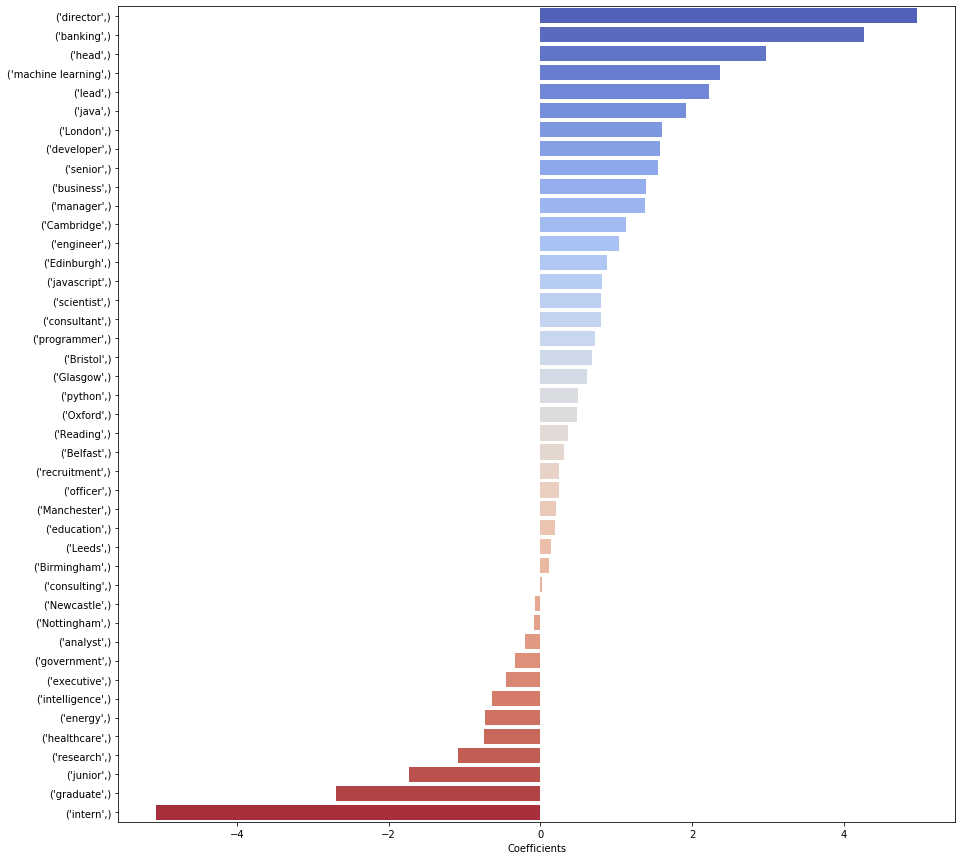

In [131]:
coeff_df = pd.DataFrame(gs_lr.best_estimator_.coef_, columns = [X.columns], index = ['Coefficients']).T.sort_values('Coefficients', ascending = False)

fig,ax= plt.subplots(figsize=(15,15))
sns.barplot(y=coeff_df.index, x=coeff_df.Coefficients, orient='h', palette='coolwarm',ax=ax);

In [24]:
predictions = gs_lr.best_estimator_.predict(X_test)

In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report


In [101]:
pd.DataFrame(confusion_matrix(y_test, predictions), index = ['actual LOW', 'actual HIGH'], 
             columns = ['predicted LOW', 'predicted HIGH'])

,predicted LOW,predicted HIGH
actual LOW,161,81
actual HIGH,58,202


In [103]:
pd.DataFrame([accuracy_score(y_test, predictions), precision_score(y_test, predictions),
              recall_score(y_test, predictions), f1_score(y_test, predictions)], columns = ['scores'], 
             index = ['accuracy','precision', 'recall', 'f1'])

,scores
accuracy,0.723108
precision,0.713781
recall,0.776923
f1,0.744015


In [104]:
# as we'd rather predict wrongly a lower salary than telling a client that they'll get a high salary when they are
# not, we want to decrease the number of false positives (81), and improve the precision score by setting a 
# higher threshold

In [105]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.74      0.67      0.70       242
           1       0.71      0.78      0.74       260

    accuracy                           0.72       502
   macro avg       0.72      0.72      0.72       502
weighted avg       0.72      0.72      0.72       502



In [106]:
predictions_df = pd.DataFrame()
predictions_df['actual']= y_test
predictions_df['predicted']= predictions
predictions_df['probability_HIGH']= gs_lr.best_estimator_.predict_proba(X_test)[:,1]
predictions_df.head()

,actual,predicted,probability_HIGH
625,1,1,0.523262
1402,0,0,0.204612
892,0,0,0.074574
1493,0,0,0.471841
1821,1,0,0.294559


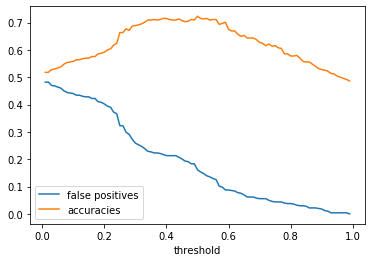

In [107]:
false_positives = []
for thresh in np.arange(1, 100)/100:
    labeled_1 = np.array([1 if x >= thresh else 0 for x in predictions_df.probability_HIGH.values])
    fp = np.mean((y_test == 0) & (labeled_1 == 1))
    false_positives.append(fp)
   

accuracy = []
for thresh in np.arange(1, 100)/100:
    labeled_1 = np.array([1 if x >= thresh else 0 for x in predictions_df.probability_HIGH.values])
    acc = np.mean(labeled_1 == y_test)
    accuracy.append(acc)
    
false_positives = np.array(false_positives)
accuracy = np.array(accuracy)
plt.plot(np.arange(1, 100)/100, false_positives, label='false positives')
plt.plot(np.arange(1, 100)/100, accuracy, label='accuracies')
plt.legend()
plt.xlabel('threshold')
plt.show()

In [120]:
predictions_df['60_precent_threshold']= predictions_df.probability_HIGH.map(lambda x:1 if x>= 0.6 else 0)
predictions_df.head()

,actual,predicted,probability_HIGH,60_precent_threshold
625,1,1,0.523262,0
1402,0,0,0.204612,0
892,0,0,0.074574,0
1493,0,0,0.471841,0
1821,1,0,0.294559,0


In [121]:
pd.DataFrame([accuracy_score(y_test, predictions_df['60_precent_threshold']), 
              precision_score(y_test, predictions_df['60_precent_threshold']),
              recall_score(y_test, predictions_df['60_precent_threshold']),
              f1_score(y_test, predictions_df['60_precent_threshold'])], columns = ['scores 60_percent_threshold'], 
             index = ['accuracy','precision', 'recall', 'f1'])

,scores 60_percent_threshold
accuracy,0.675299
precision,0.762162
recall,0.542308
f1,0.633708


In [122]:
pd.DataFrame(confusion_matrix(y_test, predictions_df['60_precent_threshold']), index = ['actual LOW', 'actual HIGH'], 
             columns = ['predicted LOW', 'predicted HIGH'])

,predicted LOW,predicted HIGH
actual LOW,198,44
actual HIGH,119,141


In [32]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

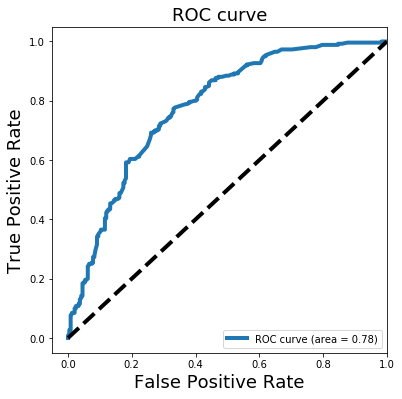

In [124]:
# For class 1, find the area under the curve
fpr, tpr, threshold = roc_curve(y_test, predictions_df.probability_HIGH)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (high salary)
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

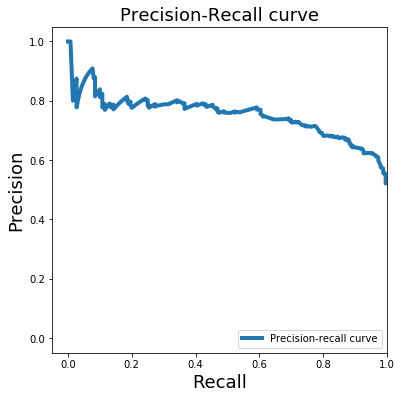

In [125]:
# For class 1, find the area under the curve
precision, recall, threshold = precision_recall_curve(y_test, predictions_df.probability_HIGH)


# Plot of a precision-recall curve for class 1 (high salary)
plt.figure(figsize=[6, 6])
plt.plot(recall, precision, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Multi-feature modelling with Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
# set up grid search with random forest model

rfc = RandomForestClassifier()

rfc_params = {'max_depth':range(1,20),
          'max_features':["auto","log2",0.5, 0.8],
         'criterion':['gini','entropy'],
         'bootstrap':[True,False]}

gs_rfc = GridSearchCV(estimator=rfc,
                     param_grid=rfc_params,
                     cv=5,
                     verbose = 1,
                    n_jobs = 2)



In [17]:
gs_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 304 candidates, totalling 1520 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  5.7min
[Parallel(n_jobs=2)]: Done 1520 out of 1520 | elapsed:  6.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [18]:
# extract the grid search results

print('Best Parameters:')
print(gs_rfc.best_params_)
print('Best estimator CV score:')
print(gs_rfc.best_score_)
print('Best estimator score on the full training set:')
print(gs_rfc.score(X_train, y_train))
print('Best estimator score on the test set:')
print(gs_rfc.score(X_test, y_test))

Best Parameters:
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto'}
Best estimator CV score:
0.7040111164873885
Best estimator score on the full training set:
0.7867463876432487
Best estimator score on the test set:
0.7051792828685259


In [143]:
ada_boost = AdaBoostClassifier(base_estimator=gs_rfc.best_estimator_,
                           n_estimators=100,
                           random_state=1)

ada_boost.fit(X_train, y_train)


print('Best estimator mean cross validated training score:')
print(cross_val_score(ada_boost, X_train, y_train, cv=5).mean())
print('Best estimator score on the full training set:')
print(ada_boost.score(X_train, y_train))
print('Best estimator score on the test set:')
print(ada_boost.score(X_test, y_test))
print('Feature importances:')
print(ada_boost.feature_importances_)

Best estimator mean cross validated training score:
0.6795821391794147
Best estimator score on the full training set:
0.809666168410563
Best estimator score on the test set:
0.7131474103585658
Feature importances:


/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:578: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan]


In [ ]:
# the score is worse with ada boost so i will only consider the original random forest classifier

In [19]:
predictions = gs_rfc.best_estimator_.predict(X_test)

In [22]:
pd.DataFrame(confusion_matrix(y_test, predictions), index = ['actual LOW', 'actual HIGH'], 
             columns = ['predicted LOW', 'predicted HIGH'])

,predicted LOW,predicted HIGH
actual LOW,153,89
actual HIGH,59,201


In [23]:
pd.DataFrame([accuracy_score(y_test, predictions), precision_score(y_test, predictions),
              recall_score(y_test, predictions), f1_score(y_test, predictions)], columns = ['scores'], 
             index = ['accuracy','precision', 'recall', 'f1'])

,scores
accuracy,0.705179
precision,0.693103
recall,0.773077
f1,0.730909


In [24]:
predictions_df = pd.DataFrame()
predictions_df['actual']= y_test
predictions_df['predicted']= predictions
predictions_df['probability_HIGH']= gs_rfc.best_estimator_.predict_proba(X_test)[:,1]
predictions_df.head()

,actual,predicted,probability_HIGH
625,1,1,0.528968
1402,0,0,0.289299
892,0,0,0.252292
1493,0,1,0.563760
1821,1,0,0.284760


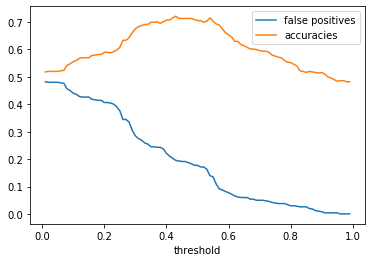

In [27]:
false_positives = []
for thresh in np.arange(1, 100)/100:
    labeled_1 = np.array([1 if x >= thresh else 0 for x in predictions_df.probability_HIGH.values])
    fp = np.mean((y_test == 0) & (labeled_1 == 1))
    false_positives.append(fp)
   

accuracy = []
for thresh in np.arange(1, 100)/100:
    labeled_1 = np.array([1 if x >= thresh else 0 for x in predictions_df.probability_HIGH.values])
    acc = np.mean(labeled_1 == y_test)
    accuracy.append(acc)
    
false_positives = np.array(false_positives)
accuracy = np.array(accuracy)
plt.plot(np.arange(1, 100)/100, false_positives, label='false positives')
plt.plot(np.arange(1, 100)/100, accuracy, label='accuracies')
plt.legend()
plt.xlabel('threshold')
plt.show()

In [28]:
predictions_df['60_precent_threshold']= predictions_df.probability_HIGH.map(lambda x:1 if x>= 0.6 else 0)
predictions_df.head()

,actual,predicted,probability_HIGH,60_precent_threshold
625,1,1,0.528968,0
1402,0,0,0.289299,0
892,0,0,0.252292,0
1493,0,1,0.563760,0
1821,1,0,0.284760,0


In [29]:
pd.DataFrame([accuracy_score(y_test, predictions_df['60_precent_threshold']), 
              precision_score(y_test, predictions_df['60_precent_threshold']),
              recall_score(y_test, predictions_df['60_precent_threshold']),
              f1_score(y_test, predictions_df['60_precent_threshold'])], columns = ['scores 60_percent_threshold'], 
             index = ['accuracy','precision', 'recall', 'f1'])

,scores 60_percent_threshold
accuracy,0.653386
precision,0.762195
recall,0.480769
f1,0.589623


In [30]:
pd.DataFrame(confusion_matrix(y_test, predictions_df['60_precent_threshold']), index = ['actual LOW', 'actual HIGH'], 
             columns = ['predicted LOW', 'predicted HIGH'])

,predicted LOW,predicted HIGH
actual LOW,203,39
actual HIGH,135,125


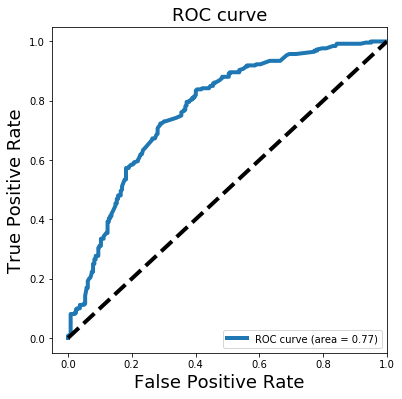

In [33]:
# For class 1, find the area under the curve
fpr, tpr, threshold = roc_curve(y_test, predictions_df.probability_HIGH)
roc_auc = auc(fpr, tpr)

# Plot of a ROC curve for class 1 (high salary)
plt.figure(figsize=[6, 6])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

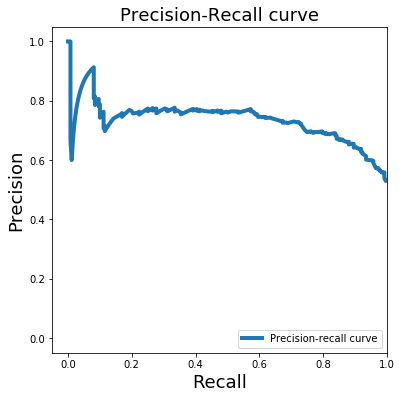

In [34]:
# For class 1, find the area under the curve
precision, recall, threshold = precision_recall_curve(y_test, predictions_df.probability_HIGH)


# Plot of a precision-recall curve for class 1 (high salary)
plt.figure(figsize=[6, 6])
plt.plot(recall, precision, label='Precision-recall curve', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision-Recall curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Summary

Step1: Search on indeed.com for data scientist, data analyst, data engineer and data science jobs in different UK cities and scrape job title, company and salary for each job posting, then add the search location to the dataframe. It's better not to scrape location but just append it from search location because some posting might specify the neighbourood and not the city itself.

Step2: clean the salary column and only consider job posting with an explicit salary a year (mean if range is explicited). EDA shows that median salary is 37500£ a year so i split salaries between high and low considering the median. Baseline accuracy: 0.5173375846950976.

Step3: in order to model using only location as features, I dummify locations and drop liverpool because it has the lowest mean salary. I then use LogisticRegression with GridSearch (CV score 0.5739779903475143) and DecisionTreeClassifier with GridSearch (CV score 0.5739817123857025) + Boosting (CV score 0.5704966439622338). By looking at the coefficients we notice that higher salaries are associated with cities like Cambridge and London

Step4: I categorise company and job titles by keywords, dummify the variables and join the new df with the dummified cities. EDA shows that many job postings include "analyst" in the title and the majority of these jobs are posted by recruitment companies, which will be useless for modelling later

Step5: I convert the df to a sparse matrix to make calculations quicker. The LogisticRegression with GridSearch (CV score 0.6940484609372093) indicate that keywords like "Director" and "Banking" are associated to higher salaries, whereas "Intern", "Graduate" and "Junior" are indicator of a low salary. I also tried RandomForestClassifier with GridSearch and got a better CV score 0.7040111164873885. AdaBoost does not improve the score.

Step6: to address the problem of misclassifying a lower paying job rather than telling a client incorrectly that they would get a high salary job, I need to minimise false positives by improving my precision score and threshold. Incresing the threshold to 60%, thus classifying anything with less than 60% probability as low income, I make my model less accurate but with a higher precision. This trade-off is shown by the roc curve. 